# Search: Solving a maze

Total Points: 10


The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

<b>Mitchell Morrison</b> <br>
CS 5320 <br>
4 October 2020

__Notes:__ 
* This is a planing exercise, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.
* Tree search algorithm implementations that you find online have often a different aim. The algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 
* Some mazes may contain cycles and therefore not form proper trees unless cycles are prevented. 

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation.

In [4]:
%run maze_helper.py


# maze = parse_maze(maze_str)

# # look at two positions in the maze
# print("Position(0,0):", maze[0, 0])

# # there is also a helper function called `look(maze, pos)`
# print("Position(8,1):", look(maze, [8, 1]))

# find_pos(maze, 'S')


Visualize the maze

In [8]:
#show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [9]:
#print("Start location:", find_pos(maze, what = "S"))
#print("Goal location:", find_pos(maze, what = "G"))

## Tree structures

A basic tree implementation in Python is available at https://github.com/yoyzhou/pyTree (found by John Park).


# Tasks

Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Iterative deepening search (IDS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[empty maze](empty_maze.txt), 
[wall maze](wall_maze.txt), 
and the 
[loops maze](loops_maze.txt). 
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:


<b>Initial state: </b>starting location specified in the maze string by the letter 'S' <br/>
<b>Actions:</b> can travel left, right, up, and down as specified by adding to the x or y values of the current location <br/>
<b>Transition Model:</b> Actions have their expected affects, except if the action brings the current location into a wall or if it attempts to move into an already visited node it will not execute.<br/>
<b>Goal State: </b>attempt to reach this location on the maze specified in the maze string by the letter 'G'<br/>
<b>Path cost: </b>all actions have a cost of 1. We will explore minimizing this cost through different search <br/>algorithms

## Task 2: Breadth-first, Depth-first and iterative deepening search [4 points]

Implement these search strategies. You can implement a generic tree search following the BFS pseudo-code in your textbook and then just adapt the order in which the frontier is explored.

In [265]:
import numpy as np
import pandas as pd
from pyTree.Tree import Tree as Tree
import matplotlib.pyplot as plt
from matplotlib import colors
import time


class Search():
    def __init__(self, search_type, verbose=True):
        ''' initialize variables for search '''
        self.search_type = search_type
        self.tree = None 
        self.maze = None 
        self.path = None
        self.goal = None
        self.start = None
        self.frontier = None
        self.frontierMax = 0 # largest size of frontier list
        self.max_depth = 0 # current max depth, updated for IDS
        self.visited = set() # set of locations visited
        self.deepestVisited = 0 # deepest amount of layers visited
        self.verbose = verbose
    
    def maze_to_int(self, maze):
        ''' tranform string to maze identifiable by ints for specific types'''
        # code from helper file
        maze = maze.split('\n')
        maze = np.array([[tile for tile in row] for row in maze if len(row) > 0])
        maze[maze == ' '] = 0  # open space
        maze[maze == 'X'] = 1  # wall
        maze[maze == 'S'] = 2  # start
        maze[maze == 'G'] = 3  # goal
        maze = maze.astype(int)
        return maze
    
    def show_maze(self, maze):  
        """display a maze (numpy array)"""
        # code from helper file
        cmap = colors.ListedColormap(['white', 'black', 'blue', 'green', 'red', 'gray'])
        bounds = [0, 1, 2, 3, 4, 5, 6]
        # make a deep copy first so the original maze is not changed
        maze = np.copy(maze)
        # gray out visited squares
        for loc in self.visited:
            maze[loc] = 5
        # red out the path to finish
        for loc in self.path:
            maze[loc] = 4
        s = self.start
        e = self.goal
        maze[s] = 2
        maze[e] = 3
        maze = maze.astype(np.int)

        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots()
        ax.imshow(maze, cmap=cmap, norm=norm)

        plt.show()

    def get_start(self):
        ''' return start state location '''
        return np.argwhere(self.maze == 2)[0]

    def get_goal(self):
        ''' return goal state location'''
        return np.argwhere(self.maze == 3)[0]
    
    def get_depth(self, node):
        ''' return amount of layers between node and root '''
        layers = 0
        while not node.isRoot():
            node = node.getParent()
            if len(node.getChildren()) >= 1:
                layers += 1
        return layers
    
    def directions(self, node):
        """ return list of possible moves """
        loc = node.data
        x = loc[1]; y = loc[0]
        # remove directions that run into wall
        # only return non visited locations
        dirs = [
            (y, x+1),
            (y, x-1),
            (y+1, x),
            (y-1, x)
        ]
        # remove visited location options
        dirs = [dir for dir in dirs if tuple(dir) not in self.visited]
        # remove wall location options
        dirs = [dir for dir in dirs if self.maze[dir] != 1]
        # return shuffled for fair direction picking
        np.random.shuffle(dirs) 
        return dirs
    
    def return_route(self, node):
        ''' get route back to the root '''
        path = []
        path.append(node.data)
        while not node.isRoot():
            node = node.getParent()
            path.append(node.data)
        return path
    
    def check_frontier(self, frontier, node):
        ''' verify node is not already in frontier '''
        for n in frontier:
            if list(n.data) == list(node.data):
                return False
        return True
    
    def reset_frontier(self):
        ''' reset variables for IDS to perform next iteration '''
        self.visited = set()
        self.tree = Tree(data=self.start)
        self.frontier = [self.tree]
        self.max_depth += 1
    
    def manhattan(self, loc):
        # calculate list of manhattan distances to start given list of nodes
        # sum of x and y distance to the point
        goalX = self.goal[1]
        goalY = self.goal[0]
        return abs(loc[1]-goalX) + abs(loc[0]-goalY)
    
    def search(self, maze):
        ''' conduct search ''' 
        self.maze = self.maze_to_int(maze)
        # show_maze(self.maze) 
        self.start = tuple(self.get_start())
        if self.verbose: print("START:", self.start)
        self.goal = tuple(self.get_goal())
        if self.verbose: print("GOAL:", self.goal)
        tree = Tree(data=self.start)
        self.frontier = [tree] # list of nodes
        self.max_depth = 1 # depth for IDS
        
        # run loop until frontier is empty
        while len(self.frontier) > 0:
            if len(self.frontier) > self.frontierMax:
                # store the largest size of the frontier
                self.frontierMax = len(self.frontier)
            if self.search_type == 'BFS':
                # bfs takes from front of frontier - priority queue
                node = self.frontier.pop(0)
            elif self.search_type == 'DFS' or self.search_type == 'IDS':
                # ifs and dfs take from end of list - stack
                node = self.frontier.pop(-1)
            elif self.search_type == 'GBFS' or self.search_type == 'A*':
                # greedy best first search uses manhattan distance to choose from frontier
                heuristic = [self.manhattan(node.data) for node in self.frontier]
                if self.search_type == 'A*':
                    # A* uses same manhattan distance + distance from start
                    distsFromStart = [len(self.return_route(node)) for node in self.frontier]
                    heuristic = np.add(distsFromStart, heuristic)
                node = self.frontier.pop(np.argmin(heuristic))                
            else:
                print("Not an accurate search type")
                return
            
            self.visited.add(tuple(node.data))
            dirs = self.directions(node)
            # add node in each returned direction to frontier
            for loc in dirs:
                # if location is empty and not in frontier then visit
                if self.maze[loc] == 0 and self.check_frontier(self.frontier, node): 
                    # add new child node to tree
                    child = Tree(data=loc)
                    node.addChild(child) 
                    if self.get_depth(child) > self.deepestVisited:
                        self.deepestVisited = self.get_depth(child)
                    if self.search_type == "IDS":
                        if self.get_depth(child) <= self.max_depth:
                            self.frontier.append(child)
                        else:
                            # at max depth for the search
                            continue
                    else: 
                        self.frontier.append(child) 
                    
                elif self.maze[loc] == 3 and self.check_frontier(self.frontier, node):
                    child = Tree(data=loc)
                    node.addChild(child)
                    self.path = self.return_route(child)
                    if self.get_depth(child) > self.deepestVisited:
                        self.deepestVisited = self.get_depth(child)
                    if self.verbose:
    #                     print("PATH TO GOAL:", self.path)
                        print("PATH TO GOAL LENGTH:", len(self.path))
                        print("MAX FRONTIER SIZE:", self.frontierMax)
                        print("DEEPEST LAYER VISITED:", self.deepestVisited)
                        print("NODES EXPANDED:", len(self.visited))
                        self.show_maze(self.maze)
                    return [len(self.path), self.frontierMax, self.deepestVisited, len(self.visited)], self.path
           # print("Frontier: ", [i.data for i in self.frontier])
            
            if len(self.frontier) == 0:
                # if frontier is empty in IDS reset contents
                # this if block could cause issues if there is no path to finish and could loop forever
                self.reset_frontier()      

START: (3, 11)
GOAL: (8, 1)
PATH TO GOAL LENGTH: 20
MAX FRONTIER SIZE: 9
DEEPEST LAYER VISITED: 19
NODES EXPANDED: 90


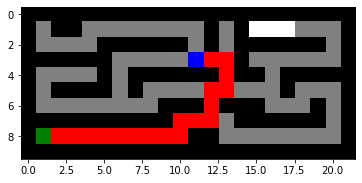

START: (1, 34)
GOAL: (16, 1)
PATH TO GOAL LENGTH: 69
MAX FRONTIER SIZE: 9
DEEPEST LAYER VISITED: 68
NODES EXPANDED: 267


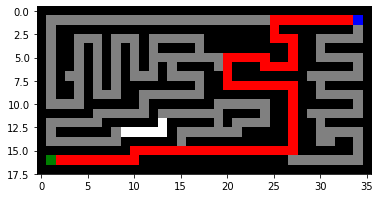

START: (35, 35)
GOAL: (35, 1)
PATH TO GOAL LENGTH: 211
MAX FRONTIER SIZE: 8
DEEPEST LAYER VISITED: 210
NODES EXPANDED: 616


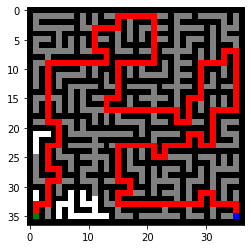

START: (1, 35)
GOAL: (21, 1)
PATH TO GOAL LENGTH: 55
MAX FRONTIER SIZE: 45
DEEPEST LAYER VISITED: 54
NODES EXPANDED: 681


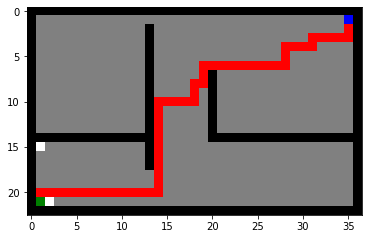

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 15
MAX FRONTIER SIZE: 20
DEEPEST LAYER VISITED: 14
NODES EXPANDED: 94


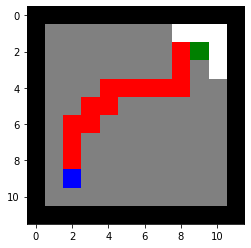

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 15
MAX FRONTIER SIZE: 18
DEEPEST LAYER VISITED: 14
NODES EXPANDED: 85


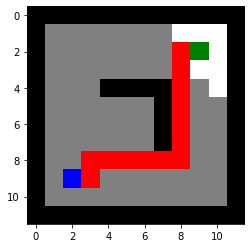

START: (10, 1)
GOAL: (1, 1)
PATH TO GOAL LENGTH: 24
MAX FRONTIER SIZE: 10
DEEPEST LAYER VISITED: 23
NODES EXPANDED: 71


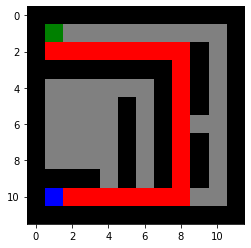

                small  medium  large   open  empty   wall  loops
PATH COST        20.0    69.0  211.0   55.0   15.0   15.0   24.0
MAX FRONTIER      9.0     9.0    8.0   45.0   20.0   18.0   10.0
DEEPEST LAYER    19.0    68.0  210.0   54.0   14.0   14.0   23.0
NODES EXPANDED   90.0   267.0  616.0  681.0   94.0   85.0   71.0
TIME (ms)       182.4   204.5  238.8  238.0  173.0  182.9  180.8

 ALL PATHS:
('small', [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (7, 10), (7, 11), (7, 12), (6, 12), (5, 12), (5, 13), (4, 13), (3, 13), (3, 12), (3, 11)])
('medium', [(16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (14, 27), (13, 27), (12, 27), (11, 27), (10, 27), (9, 27), (8, 27), (8, 26), (8, 25), (8, 24), (8, 23), (8, 22), (8, 21), (8, 20), 

,small,medium,large,open,empty,wall,loops
PATH COST,20.0,69.0,211.0,55.0,15.0,15.0,24.0
MAX FRONTIER,9.0,9.0,8.0,45.0,20.0,18.0,10.0
DEEPEST LAYER,19.0,68.0,210.0,54.0,14.0,14.0,23.0
NODES EXPANDED,90.0,267.0,616.0,681.0,94.0,85.0,71.0
TIME (ms),182.4,204.5,238.8,238.0,173.0,182.9,180.8


In [261]:
def runBFS(mazeList, mazeNames, verbose=True):
    mazeResults = []
    paths = []
    for maze in mazeList:
        BFS = Search('BFS', verbose)
        start = time.time()
        values, path = BFS.search(maze)
        totalTime = time.time() - start
        values.append(round(totalTime*1000,1))
        mazeResults.append(np.array(values))
        paths.append(path)
    df = pd.DataFrame.from_records(data=np.array(mazeResults).T, columns=mazeNames)
    df.rename(index={0:"PATH COST", 1:"MAX FRONTIER", 2:"DEEPEST LAYER", 3:"NODES EXPANDED", 4:"TIME (ms)"}, inplace=True)
    if verbose: print(df)
    allPaths = list(zip(mazeNames, paths))
    if verbose: print('\n', "ALL PATHS:")
    if verbose: print(*allPaths, sep='\n')
    return df
    
runBFS(mazeStrs, mazes)

START: (3, 11)
GOAL: (8, 1)
PATH TO GOAL LENGTH: 50
MAX FRONTIER SIZE: 7
DEEPEST LAYER VISITED: 49
NODES EXPANDED: 68


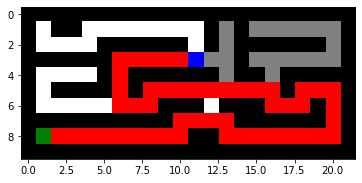

START: (1, 34)
GOAL: (16, 1)
PATH TO GOAL LENGTH: 151
MAX FRONTIER SIZE: 14
DEEPEST LAYER VISITED: 150
NODES EXPANDED: 163


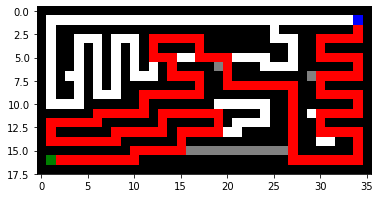

START: (35, 35)
GOAL: (35, 1)
PATH TO GOAL LENGTH: 211
MAX FRONTIER SIZE: 37
DEEPEST LAYER VISITED: 210
NODES EXPANDED: 393


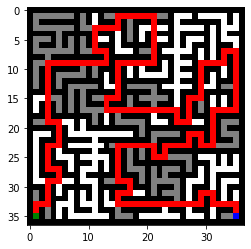

START: (1, 35)
GOAL: (21, 1)
PATH TO GOAL LENGTH: 89
MAX FRONTIER SIZE: 158
DEEPEST LAYER VISITED: 109
NODES EXPANDED: 281


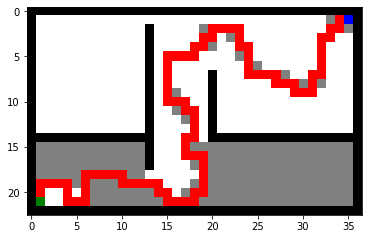

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 39
MAX FRONTIER SIZE: 48
DEEPEST LAYER VISITED: 39
NODES EXPANDED: 72


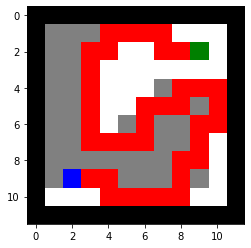

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 29
MAX FRONTIER SIZE: 35
DEEPEST LAYER VISITED: 28
NODES EXPANDED: 45


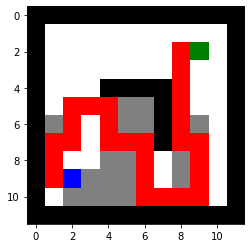

START: (10, 1)
GOAL: (1, 1)
PATH TO GOAL LENGTH: 26
MAX FRONTIER SIZE: 9
DEEPEST LAYER VISITED: 28
NODES EXPANDED: 41


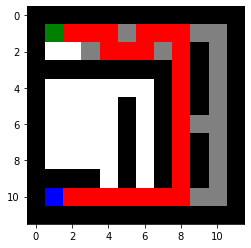

                small  medium  large   open  empty   wall  loops
PATH COST        50.0   151.0  211.0   89.0   39.0   29.0   26.0
MAX FRONTIER      7.0    14.0   37.0  158.0   48.0   35.0    9.0
DEEPEST LAYER    49.0   150.0  210.0  109.0   39.0   28.0   28.0
NODES EXPANDED   68.0   163.0  393.0  281.0   72.0   45.0   41.0
TIME (ms)       186.9   209.7  228.0  242.5  174.1  172.2  171.6

 ALL PATHS:
('small', [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (7, 10), (7, 11), (7, 12), (7, 13), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19), (8, 20), (7, 20), (6, 20), (5, 20), (5, 19), (5, 18), (6, 18), (6, 17), (6, 16), (5, 16), (5, 15), (5, 14), (5, 13), (5, 12), (5, 11), (5, 10), (5, 9), (5, 8), (6, 8), (6, 7), (6, 6), (5, 6), (4, 6), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11)])
('medium', [(16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (1

,small,medium,large,open,empty,wall,loops
PATH COST,50.0,151.0,211.0,89.0,39.0,29.0,26.0
MAX FRONTIER,7.0,14.0,37.0,158.0,48.0,35.0,9.0
DEEPEST LAYER,49.0,150.0,210.0,109.0,39.0,28.0,28.0
NODES EXPANDED,68.0,163.0,393.0,281.0,72.0,45.0,41.0
TIME (ms),186.9,209.7,228.0,242.5,174.1,172.2,171.6


In [262]:
def runDFS(mazeList, mazeNames, verbose=True):
    mazeResults = []
    paths = []
    for maze in mazeList:
        DFS = Search('DFS', verbose)
        start = time.time()
        values, path = DFS.search(maze)
        totalTime = time.time() - start
        values.append(round(totalTime*1000, 1))        
        mazeResults.append(np.array(values))
        paths.append(path)
    df = pd.DataFrame.from_records(data=np.array(mazeResults).T, columns=mazeNames)
    df.rename(index={0:"PATH COST", 1:"MAX FRONTIER", 2:"DEEPEST LAYER", 3:"NODES EXPANDED", 4:"TIME (ms)"}, inplace=True)
    if verbose: print(df)
    allPaths = list(zip(mazeNames, paths))
    if verbose: print('\n', "ALL PATHS:")
    if verbose: print(*allPaths, sep='\n')
    return df
    
runDFS(mazeStrs, mazes)

START: (3, 11)
GOAL: (8, 1)
PATH TO GOAL LENGTH: 20
MAX FRONTIER SIZE: 7
DEEPEST LAYER VISITED: 19
NODES EXPANDED: 84


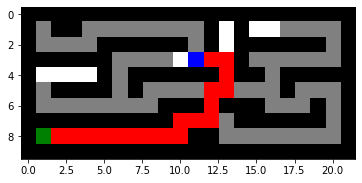

START: (1, 34)
GOAL: (16, 1)
PATH TO GOAL LENGTH: 69
MAX FRONTIER SIZE: 9
DEEPEST LAYER VISITED: 72
NODES EXPANDED: 135


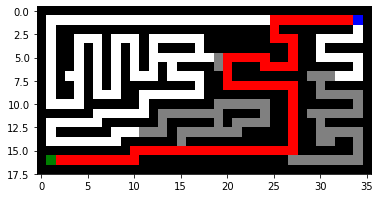

START: (35, 35)
GOAL: (35, 1)
PATH TO GOAL LENGTH: 211
MAX FRONTIER SIZE: 47
DEEPEST LAYER VISITED: 210
NODES EXPANDED: 398


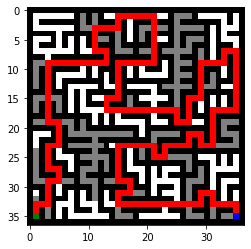

START: (1, 35)
GOAL: (21, 1)
PATH TO GOAL LENGTH: 67
MAX FRONTIER SIZE: 104
DEEPEST LAYER VISITED: 71
NODES EXPANDED: 299


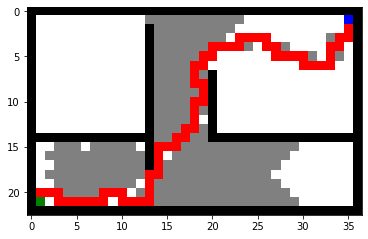

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 15
MAX FRONTIER SIZE: 22
DEEPEST LAYER VISITED: 14
NODES EXPANDED: 83


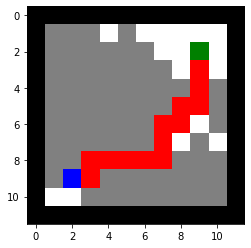

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 19
MAX FRONTIER SIZE: 24
DEEPEST LAYER VISITED: 18
NODES EXPANDED: 31


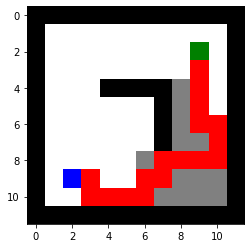

START: (10, 1)
GOAL: (1, 1)
PATH TO GOAL LENGTH: 30
MAX FRONTIER SIZE: 15
DEEPEST LAYER VISITED: 29
NODES EXPANDED: 58


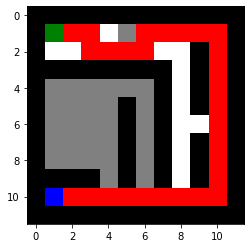

                small  medium   large    open  empty   wall  loops
PATH COST        20.0    69.0   211.0    67.0   15.0   19.0   30.0
MAX FRONTIER      7.0     9.0    47.0   104.0   22.0   24.0   15.0
DEEPEST LAYER    19.0    72.0   210.0    71.0   14.0   18.0   29.0
NODES EXPANDED   84.0   135.0   398.0   299.0   83.0   31.0   58.0
TIME (ms)       205.0   647.7  7099.4  2233.4  200.7  204.6  214.8

 ALL PATHS:
('small', [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (7, 10), (7, 11), (7, 12), (6, 12), (5, 12), (5, 13), (4, 13), (3, 13), (3, 12), (3, 11)])
('medium', [(16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (14, 27), (13, 27), (12, 27), (11, 27), (10, 27), (9, 27), (8, 27), (8, 26), (8, 25), (8, 24), (8, 23), (8, 22), (8, 21

,small,medium,large,open,empty,wall,loops
PATH COST,20.0,69.0,211.0,67.0,15.0,19.0,30.0
MAX FRONTIER,7.0,9.0,47.0,104.0,22.0,24.0,15.0
DEEPEST LAYER,19.0,72.0,210.0,71.0,14.0,18.0,29.0
NODES EXPANDED,84.0,135.0,398.0,299.0,83.0,31.0,58.0
TIME (ms),205.0,647.7,7099.4,2233.4,200.7,204.6,214.8


In [266]:
def runIDS(mazeList, mazeNames, verbose=True):
    mazeResults = []
    paths = []
    for maze in mazeList:
        IDS = Search('IDS', verbose)
        start = time.time()
        values, path = IDS.search(maze)
        totalTime = time.time() - start
        values.append(round(totalTime*1000, 1))
        mazeResults.append(np.array(values))
        paths.append(path)
    df = pd.DataFrame.from_records(data=np.array(mazeResults).T, columns=mazeNames)
    df.rename(index={0:"PATH COST", 1:"MAX FRONTIER", 2:"DEEPEST LAYER", 3:"NODES EXPANDED", 4:"TIME (ms)"}, inplace=True)
    if verbose: print(df)
    allPaths = list(zip(mazeNames, paths))
    if verbose: print('\n', "ALL PATHS:")
    if verbose: print(*allPaths, sep='\n')
    return df
    
runIDS(mazeStrs, mazes)

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each?

<b>BFS</b> - BFS is optimal because it searches all directions expanding into each possible node in a layer before moving to the next layer of nodes. Because of this, BFS has a high space and time complexity of O(b<sup>d</sup>). BFS is a complete search because it explores all possible nodes. <br>
<b>DFS</b> - DFS is not optimal because it returns the first path it finds to the finish, even if there are other options it has not explored. Although this would lead us to expect a low space complexity, in a tree first traversal a DFS search has a O(b<sup>m</sup>) because in our worst case the tree we use stores all nodes that exist. By using the same implementation as the BFS search with the tree and visited array, we are forcing ourselves into this higher space complexity. It still has a high time complexity, O(b<sup>m</sup>), because it is not guaranteed to find a path unless it explores all options. DFS would not be complete normally beacause it can get stuck in an infinite loop, if not for checking the set of visited nodes. This optimization ensures that DFS never catches in an infinite loop therefore making the search complete.<br>
<b>IDS</b> - IDS is similar to DFS, because it employes the same search tactic of expanding to each node possible before returning up the tree to its parent nodes. The main difference is at each level of the tree it is exploring for the first time it resets its memory to restart the search. This would normally have a lower space complexity than BFS of O(bd) but the same maximum time complexity of O(b<sup>d</sup>) applies because of our data structres (visited list). If we were to remove this list and let the IDS perform normally, it would loop infinitely given certain mazes, however in non looping mazes approach the O(bd) space complexity. The visited list keeps it from looping. This search is complete, similar to BFS. IDS should be optimal, but is not in my implementation because I was unable to find a way to remove the visited nodes that are checked during the DFS before failing that owuld allow the next iteration of the DFS to explore again. If I were able to remove those nodes, then the search function should be able to explore the similar directions that are currently not possible because of the visited list. This occurs because of loops in the maze, where if a -> b -> c but d also -> c then when exploring d I am not able to add c to the frontier because the set contains that element. I am unable to find a away to program into this function a way around this looping situtation that causes IDS to not be optimal although it should be. If we were to wipe the visited list at each new traversal backup the tree of all the nodes that were below it should work.<br>

Variable meanings: <br>
b - branching factor <br>
m - maximum depth of the search tree <br>
d - depth of shallowest solution <br>

Optimal - lowest path cost possible from start to goal<br>
Complete - always finds a path should it exist


## Task 3: Greedy best-first search [2 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function.

START: (3, 11)
GOAL: (8, 1)
PATH TO GOAL LENGTH: 30
MAX FRONTIER SIZE: 5
DEEPEST LAYER VISITED: 29
NODES EXPANDED: 39


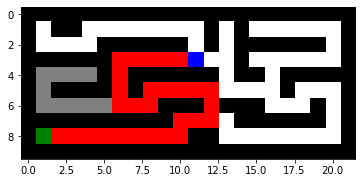

START: (1, 34)
GOAL: (16, 1)
PATH TO GOAL LENGTH: 77
MAX FRONTIER SIZE: 4
DEEPEST LAYER VISITED: 76
NODES EXPANDED: 78


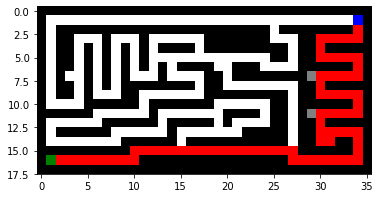

START: (35, 35)
GOAL: (35, 1)
PATH TO GOAL LENGTH: 211
MAX FRONTIER SIZE: 22
DEEPEST LAYER VISITED: 210
NODES EXPANDED: 461


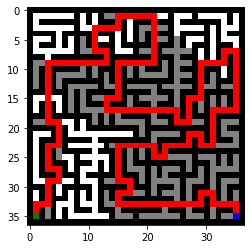

START: (1, 35)
GOAL: (21, 1)
PATH TO GOAL LENGTH: 69
MAX FRONTIER SIZE: 92
DEEPEST LAYER VISITED: 68
NODES EXPANDED: 87


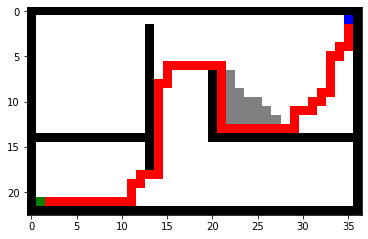

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 15
MAX FRONTIER SIZE: 28
DEEPEST LAYER VISITED: 14
NODES EXPANDED: 14


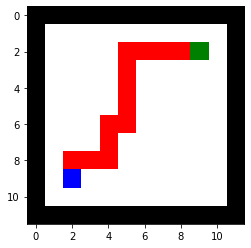

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 19
MAX FRONTIER SIZE: 28
DEEPEST LAYER VISITED: 18
NODES EXPANDED: 22


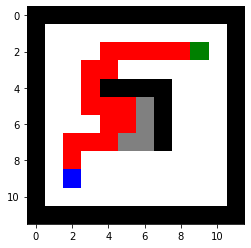

START: (10, 1)
GOAL: (1, 1)
PATH TO GOAL LENGTH: 42
MAX FRONTIER SIZE: 13
DEEPEST LAYER VISITED: 41
NODES EXPANDED: 51


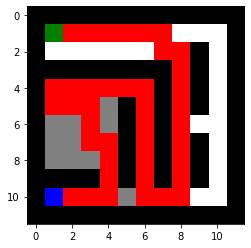

                small  medium  large   open  empty   wall  loops
PATH COST        30.0    77.0  211.0   69.0   15.0   19.0   42.0
MAX FRONTIER      5.0     4.0   22.0   92.0   28.0   28.0   13.0
DEEPEST LAYER    29.0    76.0  210.0   68.0   14.0   18.0   41.0
NODES EXPANDED   39.0    78.0  461.0   87.0   14.0   22.0   51.0
TIME (ms)       185.5   199.2  271.8  193.2  168.6  175.0  177.8

 ALL PATHS:
('small', [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (7, 10), (7, 11), (7, 12), (6, 12), (5, 12), (5, 11), (5, 10), (5, 9), (5, 8), (6, 8), (6, 7), (6, 6), (5, 6), (4, 6), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11)])
('medium', [(16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (1

,small,medium,large,open,empty,wall,loops
PATH COST,30.0,77.0,211.0,69.0,15.0,19.0,42.0
MAX FRONTIER,5.0,4.0,22.0,92.0,28.0,28.0,13.0
DEEPEST LAYER,29.0,76.0,210.0,68.0,14.0,18.0,41.0
NODES EXPANDED,39.0,78.0,461.0,87.0,14.0,22.0,51.0
TIME (ms),185.5,199.2,271.8,193.2,168.6,175.0,177.8


In [189]:
def runGBFS(mazeList, mazeNames, verbose=True):
    mazeResults = []
    paths = []
    for maze in mazeList:
        GBFS = Search('GBFS', verbose)
        start = time.time()
        values, path = GBFS.search(maze)
        totalTime = time.time() - start
        values.append(round(totalTime*1000, 1))
        mazeResults.append(np.array(values))
        paths.append(path)
    df = pd.DataFrame.from_records(data=np.array(mazeResults).T, columns=mazeNames)
    df.rename(index={0:"PATH COST", 1:"MAX FRONTIER", 2:"DEEPEST LAYER", 3:"NODES EXPANDED", 4:"TIME (ms)"}, inplace=True)
    if verbose: print(df)
    allPaths = list(zip(mazeNames, paths))
    if verbose: print('\n', "ALL PATHS:")
    if verbose: print(*allPaths, sep='\n')
    return df
    
runGBFS(mazeStrs, mazes)

Is this implementation complete and optimal? What is the time and space complexity?

<b>GBFS</b> - GBFS is not optimal as it uses a heuristic to guide its path movement and does not reexplore spaces in the frontier that may be quicker. GBFS is not complete because it does not use past knowledge to guide its decisions and can get stuck in a dead end. GBFS has significantly lower space and time complexity as it uses a heuristic function to select its next visited location from the frontier. This is a worst case space and time complexity of O(b<sup>m</sup>). These can be significantly reduced based on the effectiveness of the heurisitic and the particular problem.

## Task 4: A* Search [3 points]

Use again the Manhattan heuristic function.

START: (3, 11)
GOAL: (8, 1)
PATH TO GOAL LENGTH: 20
MAX FRONTIER SIZE: 8
DEEPEST LAYER VISITED: 19
NODES EXPANDED: 53


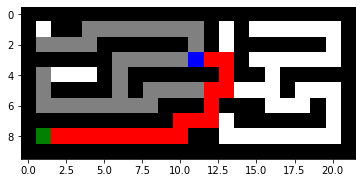

START: (1, 34)
GOAL: (16, 1)
PATH TO GOAL LENGTH: 69
MAX FRONTIER SIZE: 8
DEEPEST LAYER VISITED: 68
NODES EXPANDED: 221


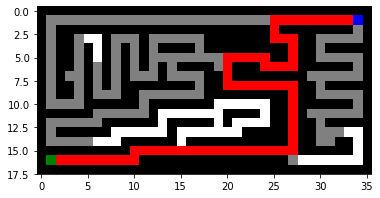

START: (35, 35)
GOAL: (35, 1)
PATH TO GOAL LENGTH: 211
MAX FRONTIER SIZE: 12
DEEPEST LAYER VISITED: 210
NODES EXPANDED: 549


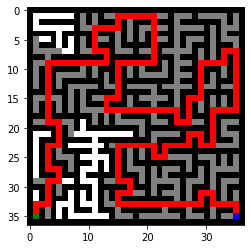

START: (1, 35)
GOAL: (21, 1)
PATH TO GOAL LENGTH: 55
MAX FRONTIER SIZE: 40
DEEPEST LAYER VISITED: 54
NODES EXPANDED: 534


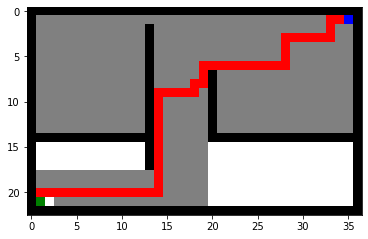

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 15
MAX FRONTIER SIZE: 32
DEEPEST LAYER VISITED: 14
NODES EXPANDED: 63


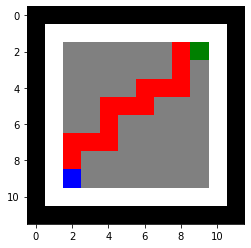

START: (9, 2)
GOAL: (2, 9)
PATH TO GOAL LENGTH: 15
MAX FRONTIER SIZE: 32
DEEPEST LAYER VISITED: 14
NODES EXPANDED: 56


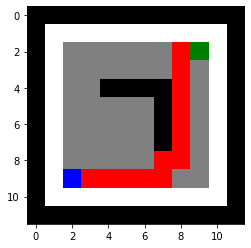

START: (10, 1)
GOAL: (1, 1)
PATH TO GOAL LENGTH: 24
MAX FRONTIER SIZE: 8
DEEPEST LAYER VISITED: 23
NODES EXPANDED: 58


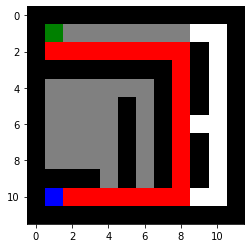

                small  medium  large   open  empty   wall  loops
PATH COST        20.0    69.0  211.0   55.0   15.0   15.0   24.0
MAX FRONTIER      8.0     8.0   12.0   40.0   32.0   32.0    8.0
DEEPEST LAYER    19.0    68.0  210.0   54.0   14.0   14.0   23.0
NODES EXPANDED   53.0   221.0  549.0  534.0   63.0   56.0   58.0
TIME (ms)       184.5   221.5  378.2  601.9  229.8  177.3  177.8

 ALL PATHS:
('small', [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (7, 10), (7, 11), (7, 12), (6, 12), (5, 12), (5, 13), (4, 13), (3, 13), (3, 12), (3, 11)])
('medium', [(16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (14, 27), (13, 27), (12, 27), (11, 27), (10, 27), (9, 27), (8, 27), (8, 26), (8, 25), (8, 24), (8, 23), (8, 22), (8, 21), (8, 20), 

,small,medium,large,open,empty,wall,loops
PATH COST,20.0,69.0,211.0,55.0,15.0,15.0,24.0
MAX FRONTIER,8.0,8.0,12.0,40.0,32.0,32.0,8.0
DEEPEST LAYER,19.0,68.0,210.0,54.0,14.0,14.0,23.0
NODES EXPANDED,53.0,221.0,549.0,534.0,63.0,56.0,58.0
TIME (ms),184.5,221.5,378.2,601.9,229.8,177.3,177.8


In [191]:
def runAStar(mazeList, mazeNames, verbose=True):
    mazeResults = []
    paths = []
    for maze in mazeList:
        AStar = Search('A*', verbose)
        start = time.time()
        values, path = AStar.search(maze)
        totalTime = time.time() - start
        values.append(round(totalTime*1000, 1))
        mazeResults.append(np.array(values))
        paths.append(path)
    df = pd.DataFrame.from_records(data=np.array(mazeResults).T, columns=mazeNames)
    df.rename(index={0:"PATH COST", 1:"MAX FRONTIER", 2:"DEEPEST LAYER", 3:"NODES EXPANDED", 4:"TIME (ms)"}, inplace=True)
    if verbose: print(df)
    allPaths = list(zip(mazeNames, paths))
    if verbose: print('\n', "ALL PATHS:")
    if verbose: print(*allPaths, sep='\n')
    return df
    
runAStar(mazeStrs, mazes)

Is this implementation complete and optimal? What is the time and space complexity?

<b>A*</b> - A* search is optimal, given it uses an admissable heuristic. My heurisitic is admissible because it used the manhattan distance of the current node + depth of the layer in the tree to pick a node from the frontier. A* is complete if a solution exists. A* has a worst case time and space complexity of O(b<sup>d</sup>) beacause it stores all nodes it visits.

Don't forget to add a table that compares the following for the algorithms on the different mazes:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

In [215]:
mazes = ['small', 'medium', 'large', 'open', 'empty', 'wall', 'loops']
searches = ['BFS', 'DFS', 'IDS', 'GBFS', 'A*']
mazeStrs = []
for m in mazes:
    f = open('{}_maze.txt'.format(m), 'r')
    mazeStrs.append(f.read())

tables = []
tables.append(runBFS(mazeStrs, mazes, verbose=False))
tables.append(runDFS(mazeStrs, mazes, verbose=False))
tables.append(runIDS(mazeStrs, mazes, verbose=False))
tables.append(runGBFS(mazeStrs, mazes, verbose=False))
tables.append(runAStar(mazeStrs, mazes, verbose=False))
for df, search in zip(tables, searches):
    print("SEARCH TYPE:", search)
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    print(df, '\n')

SEARCH TYPE: BFS
                small  medium  large   open  empty  wall  loops        mean  \
PATH COST        20.0    69.0  211.0   55.0   15.0  15.0   24.0   58.428571   
MAX FRONTIER      9.0     9.0    8.0   45.0   21.0  18.0   10.0   17.142857   
DEEPEST LAYER    19.0    68.0  210.0   54.0   14.0  14.0   23.0   57.428571   
NODES EXPANDED   90.0   266.0  619.0  681.0   93.0  86.0   70.0  272.142857   
TIME (ms)         2.5    14.1   74.0   57.9    4.5   5.3    2.4   22.957143   

                       std  
PATH COST        65.285871  
MAX FRONTIER     12.298996  
DEEPEST LAYER    65.285871  
NODES EXPANDED  247.354822  
TIME (ms)        27.770378   

SEARCH TYPE: DFS
                small  medium  large   open  empty  wall  loops        mean  \
PATH COST        30.0    69.0  211.0  165.0   37.0  29.0   24.0   80.714286   
MAX FRONTIER      6.0     7.0   34.0  230.0   49.0  32.0   10.0   52.571429   
DEEPEST LAYER    48.0    68.0  210.0  184.0   39.0  28.0   23.0   85.714286   

In [242]:
# calculate stuff with tables list from previous cells

meanDF = pd.DataFrame()
stdDF = pd.DataFrame()
for df, search in zip(tables, searches):
    # find mean, std, regression of times for each row in each table
    meanDF[search] = df['mean']
    stdDF[search] = df['std']
    
print('\n', "TABLE OF ALL SEARCH MEAN VALUES:", '\n', meanDF)
print('\n', "TABLE OF ALL SEARCH STANDARD DEVIATION VALUES:", '\n', stdDF)
    

# merging all tables data and finding general patterns among all search types and mazes
df_concat = pd.concat(tables)
by_row = df_concat.groupby(df_concat.index)
df_means = by_row.mean()
print('\n', "MEAN VALUES ACROSS ALL SEARCHES:", '\n', df_means)
df_std = by_row.std()
print('\n', "STANDARD DEVIATION VALUES ACROSS ALL SEARCHES:", '\n', df_std)


 TABLE OF ALL SEARCH MEAN VALUES: 
                        BFS         DFS          IDS        GBFS          A*
PATH COST        58.428571   80.714286    58.428571   76.142857   58.428571
MAX FRONTIER     17.142857   52.571429    17.428571   28.428571   20.000000
DEEPEST LAYER    57.428571   85.714286    57.428571   75.142857   57.428571
NODES EXPANDED  272.142857  175.714286   272.000000  118.142857  219.142857
TIME (ms)        22.957143   33.114286  1264.257143   15.514286  102.871429

 TABLE OF ALL SEARCH STANDARD DEVIATION VALUES: 
                        BFS         DFS          IDS        GBFS          A*
PATH COST        65.285871   70.294715    65.285871   70.675170   65.285871
MAX FRONTIER     12.298996   73.988140    12.116779   28.479853   13.005493
DEEPEST LAYER    65.285871   72.001417    65.285871   70.675170   65.285871
NODES EXPANDED  247.354822  191.733233   247.092233  147.008677  211.614494
TIME (ms)        27.770378   55.252445  2248.924699   19.980092  140.717972


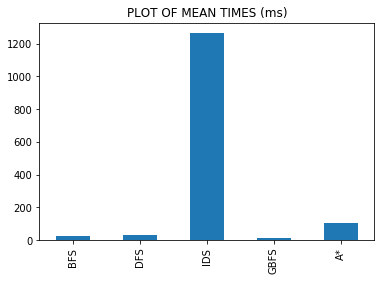

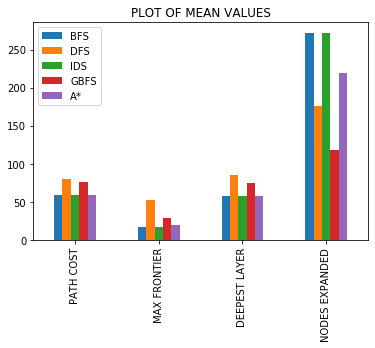

In [249]:
# bar plot of each mean and std dev for each search

times = meanDF.loc['TIME (ms)', :]
timesX = times.plot.bar(title="PLOT OF MEAN TIMES (ms)")
meanDFTemp = meanDF.drop("TIME (ms)")
ax = meanDFTemp.plot.bar(title="PLOT OF MEAN VALUES")


## Bonus Tasks [+1 point]

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [11]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [12]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [13]:
# Your code/answer goes here